In [1]:
%reset -fs

# Importing required libraries...

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
from tensorflow.keras.applications.vgg19 import VGG19
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow_addons as tfa
!pip install visualkeras
import visualkeras

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "figure.figsize" : (10,10),
          "axes.titlecolor" : 'w',
          "axes.facecolor" : 'w',
          "figure.facecolor" : 'k'}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 40.4 MB/s eta 0:00:00


### checking if GPU support is enabled for Tensorflow with the following:

In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")

if len(gpus) == 0:
    print("Not connected with GPU")
else:
    print("Connected with GPU")
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print(gpus)


Connected with GPU
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Preprocessing
Tensorflow has a handy utility known as image_dataset_from_directory, that allows you to work with a dataset that is already on your local disk:

In [4]:
image_size = (128,128)
batch_size = 32

#### Simple barplot on the total number of images present in the dataset

In [5]:
def plot_total_images(base_dir):
    data = {"category":[], "images": []}
    for key, value in zip(os.listdir(base_dir), map(lambda directory: len(os.listdir(os.path.join(base_dir, directory))), os.listdir(base_dir))):
        data["category"].append(key)
        data["images"].append(value)
    data = pd.DataFrame(data)
    plt.figure(figsize=(12, 5))
    sns.barplot(x="category", y="images", data=data, palette="mako")

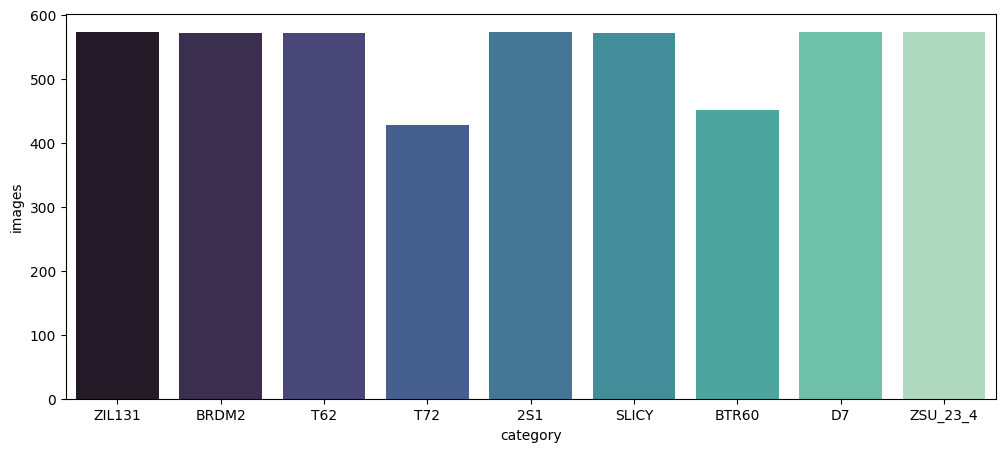

In [6]:
plot_total_images(base_dir="/kaggle/input/mstar-8-classes/MSTAR-8-Classes")


In [7]:
train_ds = image_dataset_from_directory('/kaggle/input/mstar-8-classes/MSTAR-8-Classes',
                                           subset='training',
                                           image_size=image_size,
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='grayscale',
                                           batch_size=batch_size)

val_ds = image_dataset_from_directory('/kaggle/input/mstar-8-classes/MSTAR-8-Classes',
                                           subset='validation',
                                           image_size=image_size,
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='grayscale',
                                           batch_size=batch_size)

Found 4887 files belonging to 9 classes.
Using 3910 files for training.
Found 4887 files belonging to 9 classes.
Using 977 files for validation.


##### We’ve splited the training and validation data, inferred labels from the directory structure (each class was a folder within the parent), and defined the image size, and color mode. 
##### - Here are the first 9 images of our training data and the corresponding labels using the following code:

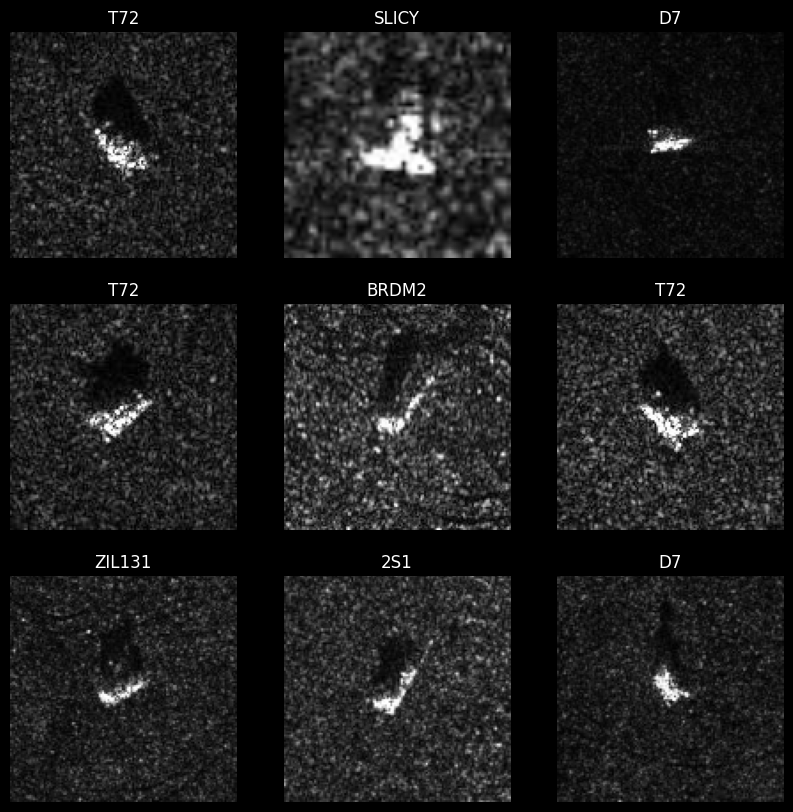

In [8]:
class_names = train_ds.class_names
with plt.rc_context(params):
  plt.figure(figsize=(10, 10))
  for images, labels in train_ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
      plt.title(class_names[np.argmax(labels[i])], )
      plt.axis("off")

In [9]:
class_names

['2S1', 'BRDM2', 'BTR60', 'D7', 'SLICY', 'T62', 'T72', 'ZIL131', 'ZSU_23_4']

#### It’s also best practice to hold out a final test dataset from our validation data. We can do that with the following code:

In [10]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 25
Number of test batches: 6


#### As the last step in our pre-processing, We used Tensorflow’s autotune capabilities to maximize the data’s performance according to our hardware, and minimize the amount of time it takes models to train:

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Define Evaluation Metrics and Functions
#### Before we got started with our first model, we wanted to define the metrics and functions we would be using to evaluate each iteration.

- Here are the metrics we used:

In [12]:
num_classes=9

metrics = [
      keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      tfa.metrics.MatthewsCorrelationCoefficient(num_classes=9, name='MCC'),
      tfa.metrics.FBetaScore(num_classes=9, average='weighted', beta=2.0, name='F2'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
]

# ANN - MLP

In [13]:
model1 = keras.Sequential()

model1.add(InputLayer(input_shape=(image_size + (1,))))

model1.add(Flatten())

model1.add(Dense(100, activation='relu'))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(100, activation='relu'))

model1.add(Dense(num_classes, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 100)               1638500   
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 9)                 909       
                                                                 
Total params: 1,659,609
Trainable params: 1,659,609
Non-trainable params: 0
_________________________________________________________________


In [14]:
model1.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=metrics)

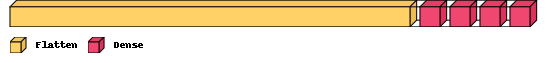

In [15]:
visualkeras.layered_view(model1, legend=True)

In [16]:
history1 = model1.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
123/123 [==============================] - 12s 19ms/step - loss: 28.7002 - categorical_accuracy: 0.3568 - MCC: 0.2767 - F2: 0.3558 - auc: 0.6823 - prc: 0.2702 - val_loss: 3.2987 - val_categorical_accuracy: 0.5490 - val_MCC: 0.5121 - val_F2: 0.5112 - val_auc: 0.8045 - val_prc: 0.5351
Epoch 2/10
123/123 [==============================] - 1s 7ms/step - loss: 1.1735 - categorical_accuracy: 0.7918 - MCC: 0.7656 - F2: 0.7912 - auc: 0.9458 - prc: 0.8305 - val_loss: 1.8571 - val_categorical_accuracy: 0.8064 - val_MCC: 0.7891 - val_F2: 0.7923 - val_auc: 0.9367 - val_prc: 0.8159
Epoch 3/10
123/123 [==============================] - 1s 6ms/step - loss: 0.5897 - categorical_accuracy: 0.8701 - MCC: 0.8536 - F2: 0.8700 - auc: 0.9754 - prc: 0.9183 - val_loss: 0.6534 - val_categorical_accuracy: 0.8624 - val_MCC: 0.8482 - val_F2: 0.8593 - val_auc: 0.9748 - val_prc: 0.9107
Epoch 4/10
123/123 [==============================] - 1s 6ms/step - loss: 0.5745 - categorical_accuracy: 0.8870 - MCC: 0.

### Function for plotting selected metrics across model epochs. 
#### We have used loss, precision-recall curve, F2, and Matthews Correlation Coefficient, but any metric TensorFlow or Tensorflowaddons can be used:

In [17]:
def plot_metrics(history):
  with plt.rc_context(params):    
    metrics = ['loss', 'prc', 'F2', 'MCC']
    plt.figure(figsize=(12,10))
    for n, metric in enumerate(metrics):
      name = metric.replace("_"," ").capitalize()
      plt.subplot(2,2,n+1)
      plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
      plt.plot(history.epoch, history.history['val_'+metric],
              color=colors[0], linestyle="--", label='Val')
      plt.xlabel('Epoch')
      plt.ylabel(name)
      if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
      elif metric == 'auc':
        plt.ylim([0.8,1])
      elif metric == 'MCC':
        plt.ylim([-1,1])
      else:
        plt.ylim([0,1])

      plt.legend();

### Function for plotting the confusion matrices for each model:

In [18]:
def plot_cm(model, data):
    with plt.rc_context(params):
        y_true = []
        y_pred = []
        for x,y in data:
            y= tf.argmax(y,axis=1)
            y_true.append(y)
            y_pred.append(tf.argmax(model.predict(x),axis = 1))
    
        y_pred = tf.concat(y_pred, axis=0)
        y_true = tf.concat(y_true, axis=0)

        cm = confusion_matrix(y_true, y_pred)
        fig = plt.figure(figsize = (10,10))
        ax1 = fig.add_subplot(1,1,1)
        sns.set(font_scale=1.4) #for label size
        sns.heatmap(cm,cmap='binary', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 10},
            cbar = False);
        ax1.set_ylabel('True Values',fontsize=14)
        ax1.set_xlabel('Predicted Values',fontsize=14)
        plt.show()

#### We also wanted a function for testing the models against the holdout data and returning the metrics defined above:

In [19]:
def holdout_results(model):
    result = model.evaluate(test_ds)
    return dict(zip(model.metrics_names, result))
    

#### Lastly, we took a T-72 image from the dataset and have each model make a prediction for it:

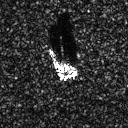

In [20]:
image = keras.utils.load_img(
    path="/kaggle/input/mstar-8-classes/MSTAR-8-Classes/T72/HB03379.jpeg",
    color_mode='grayscale',
    target_size=(128,128)
)

image_array = keras.utils.img_to_array(image)
image_array = tf.expand_dims(image_array, 0)

image

In [21]:
def predict_t72(model):
    predictions = model.predict(image_array)
    score = tf.nn.softmax(predictions[0])
    return(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

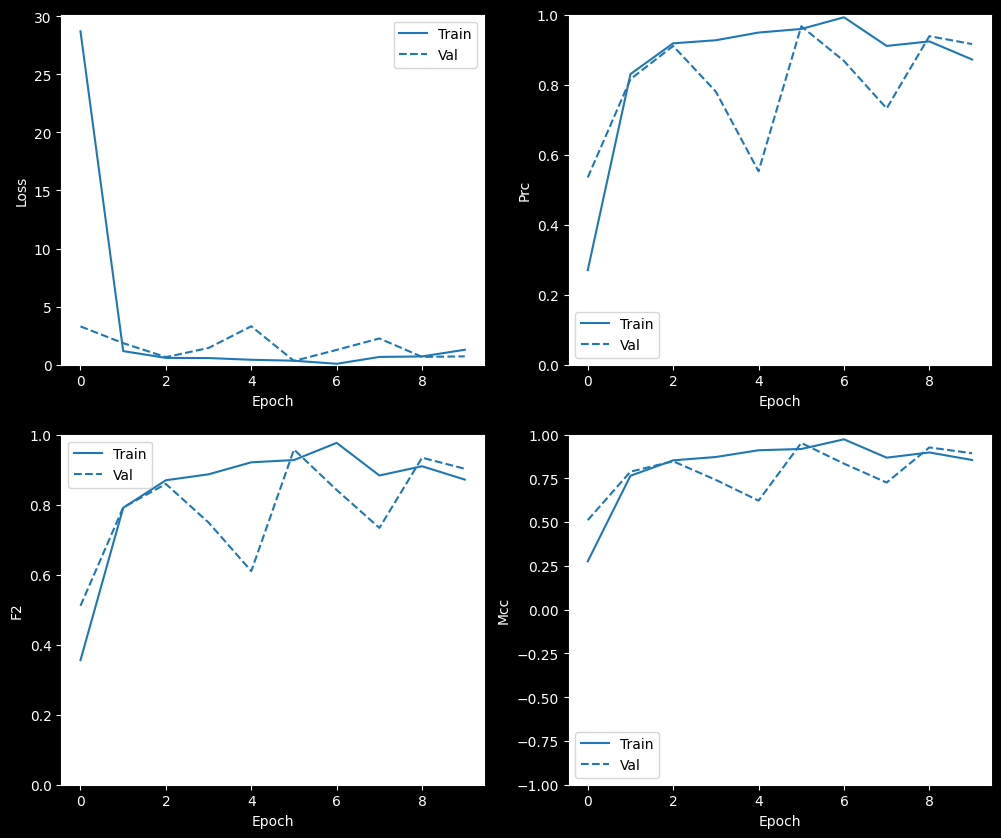

In [22]:
plot_metrics(history1)

1/1 [==============================] - 0s 57ms/step


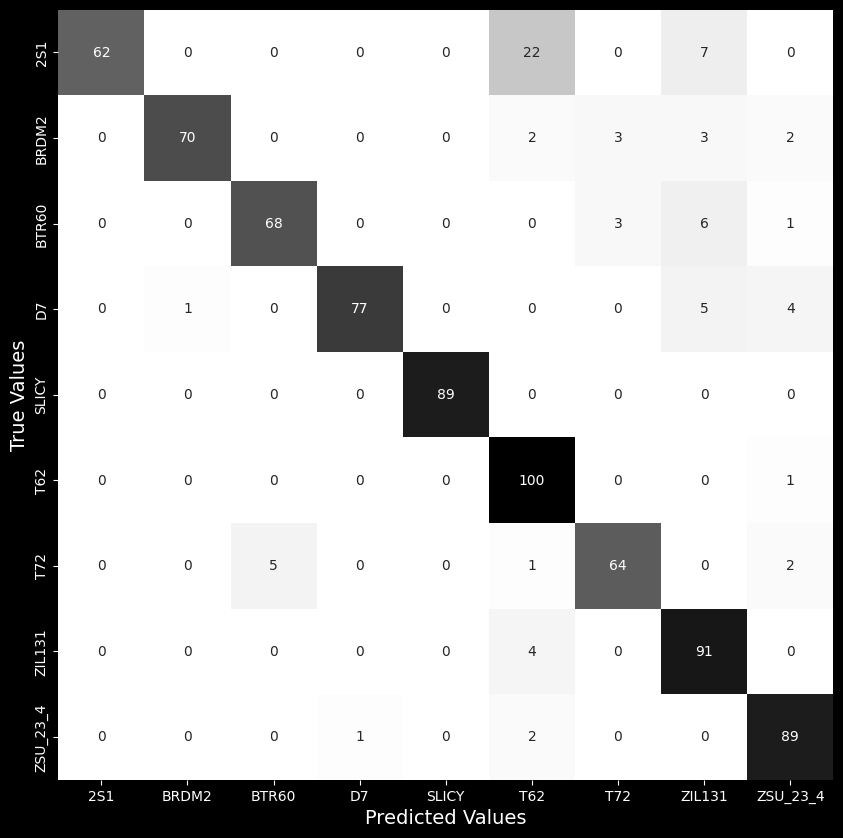

In [23]:
plot_cm(model1, val_ds)

In [24]:
holdout_results(model1)

6/6 [==============================] - 0s 14ms/step - loss: 0.9414 - categorical_accuracy: 0.8906 - MCC: 0.8783 - F2: 0.8886 - auc: 0.9663 - prc: 0.8978


{'loss': 0.9413747191429138,
 'categorical_accuracy': 0.890625,
 'MCC': 0.8783231377601624,
 'F2': 0.8886363506317139,
 'auc': 0.9662576913833618,
 'prc': 0.8978415131568909}

1/1 [==============================] - 0s 18ms/step


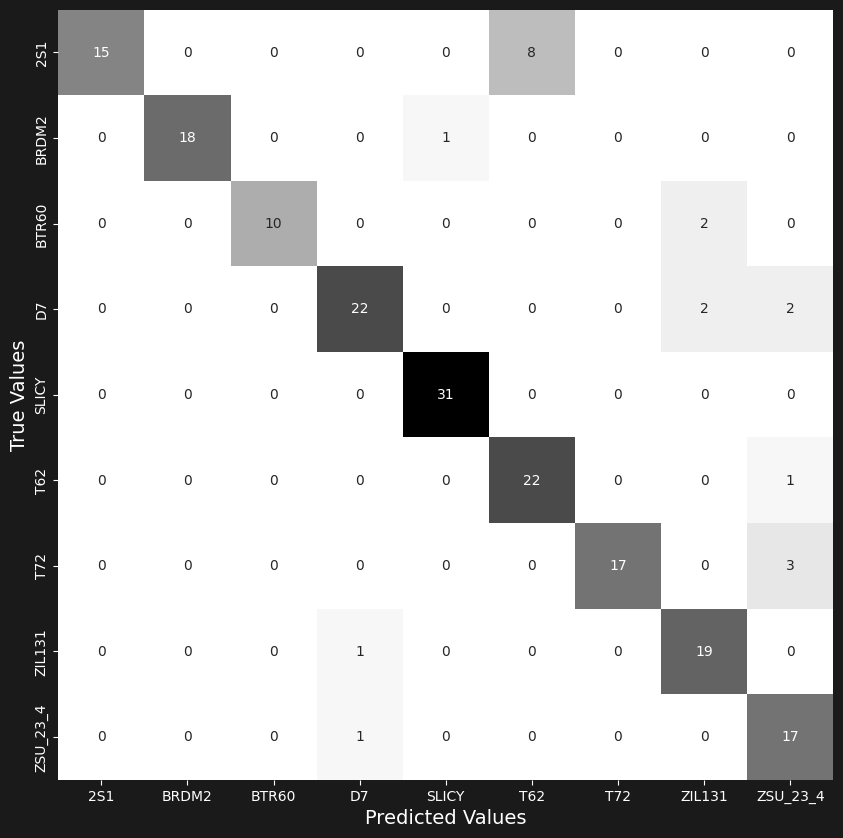

In [25]:
plot_cm(model1, test_ds)

In [26]:
predict_t72(model1)

1/1 [==============================] - 0s 19ms/step


'This image most likely belongs to T72 with a 25.36 percent confidence.'

# MODEL 1 CNN

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 10)      100       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 10)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 20)        1820      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 20)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 30)        5430      
                                                                 
 global_average_pooling2d (G  (None, 30)              

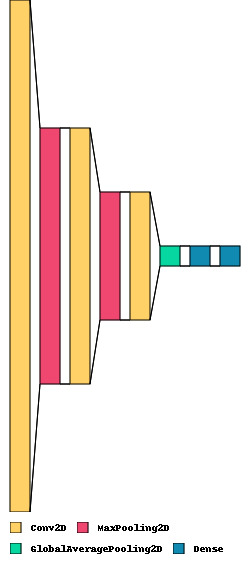

In [27]:
CNN = Sequential()
CNN.add(InputLayer(input_shape=(image_size + (1,))))
CNN.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
CNN.add(MaxPooling2D())
CNN.add(Conv2D(filters=20, kernel_size=3, activation='relu', padding='same'))
CNN.add(MaxPooling2D())
CNN.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))
CNN.add(GlobalAveragePooling2D())
CNN.add(Dense(20, activation='relu'))
CNN.add(Dense(num_classes, activation='softmax'))
CNN.summary()
visualkeras.layered_view(CNN, legend=True, draw_volume=False)

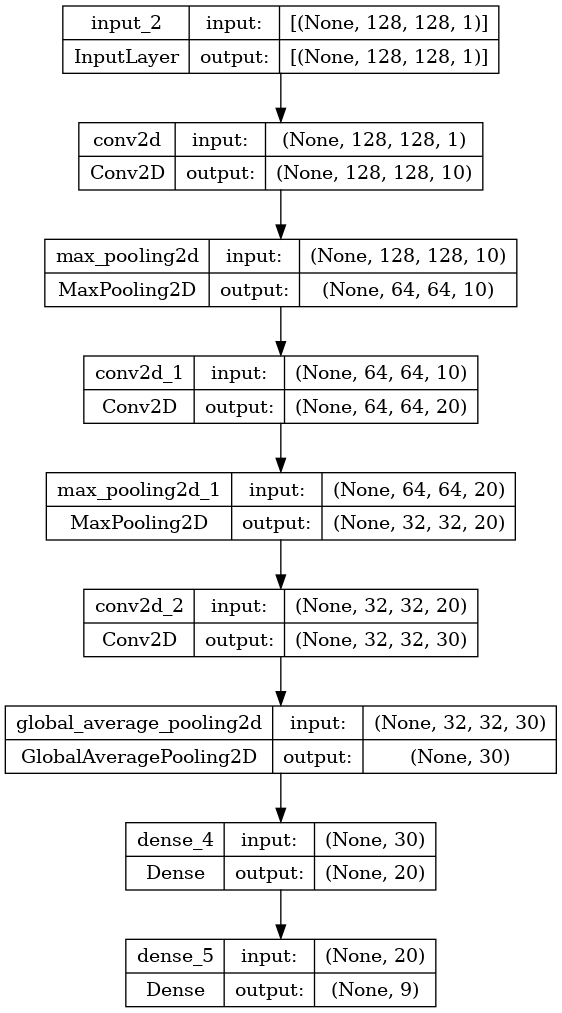

In [28]:
# display model structure
from tensorflow.keras.utils import plot_model, model_to_dot
plot_model(CNN, 'CNN.png', show_shapes=True)

In [29]:
CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metrics)

In [30]:
cnn_hist = CNN.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
123/123 [==============================] - 8s 13ms/step - loss: 2.2556 - categorical_accuracy: 0.1594 - MCC: 0.0721 - F2: 0.1162 - auc: 0.5596 - prc: 0.1733 - val_loss: 2.1962 - val_categorical_accuracy: 0.1019 - val_MCC: 0.0000e+00 - val_F2: 0.0369 - val_auc: 0.5180 - val_prc: 0.1152
Epoch 2/10
123/123 [==============================] - 1s 9ms/step - loss: 2.1939 - categorical_accuracy: 0.1225 - MCC: 0.0247 - F2: 0.0511 - auc: 0.5266 - prc: 0.1182 - val_loss: 2.1953 - val_categorical_accuracy: 0.1019 - val_MCC: 0.0000e+00 - val_F2: 0.0369 - val_auc: 0.5115 - val_prc: 0.1117
Epoch 3/10
123/123 [==============================] - 1s 8ms/step - loss: 2.0641 - categorical_accuracy: 0.1905 - MCC: 0.1244 - F2: 0.1368 - auc: 0.5954 - prc: 0.2156 - val_loss: 1.9122 - val_categorical_accuracy: 0.2548 - val_MCC: 0.2102 - val_F2: 0.1974 - val_auc: 0.7467 - val_prc: 0.3255
Epoch 4/10
123/123 [==============================] - 1s 8ms/step - loss: 1.8307 - categorical_accuracy: 0.2808 - M

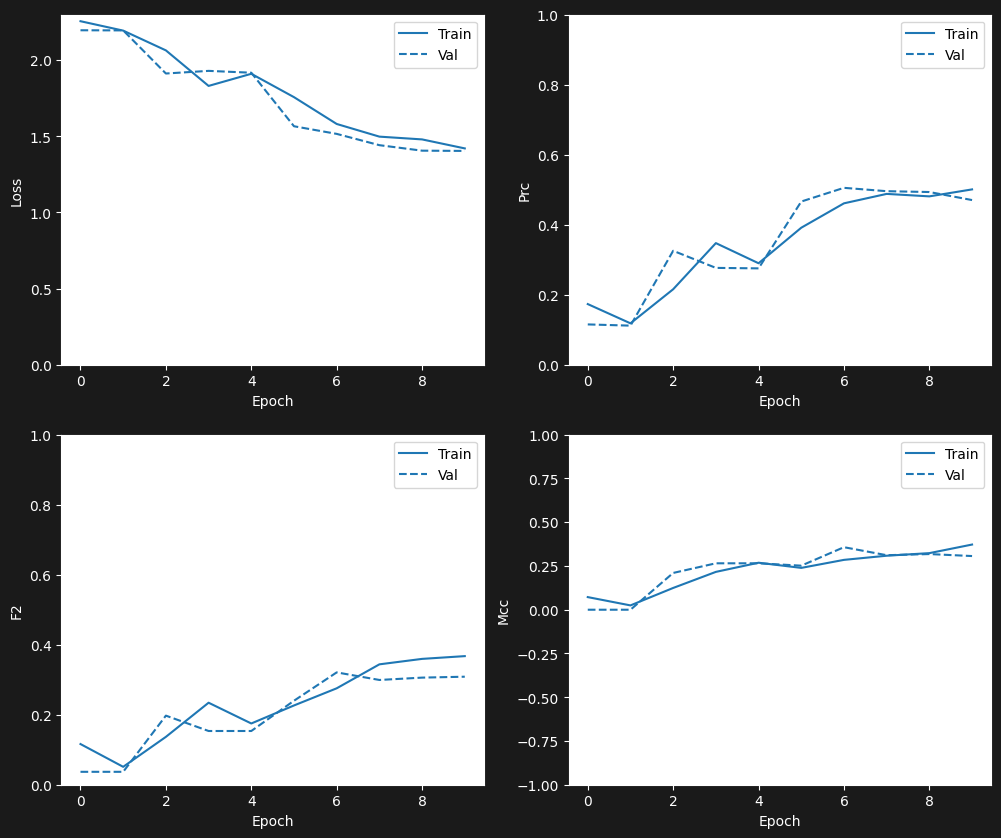

In [31]:
plot_metrics(cnn_hist)

1/1 [==============================] - 0s 78ms/step


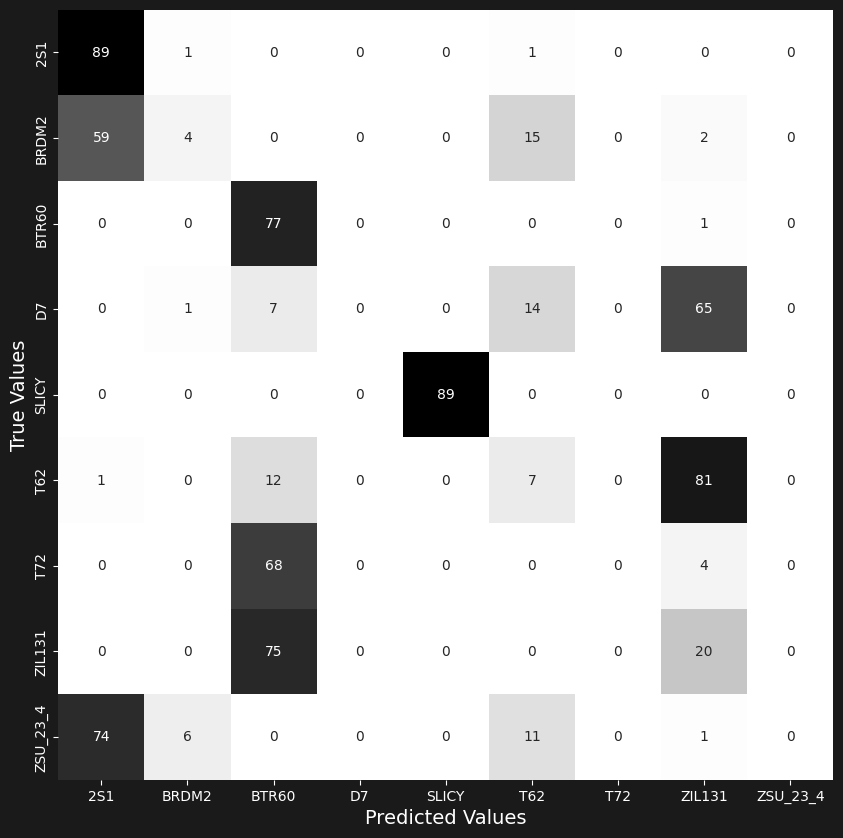

In [32]:
plot_cm(CNN, val_ds)

In [33]:
holdout_results(CNN)

6/6 [==============================] - 0s 9ms/step - loss: 1.3530 - categorical_accuracy: 0.3854 - MCC: 0.3362 - F2: 0.3391 - auc: 0.8749 - prc: 0.5000


{'loss': 1.353049397468567,
 'categorical_accuracy': 0.3854166567325592,
 'MCC': 0.3362288475036621,
 'F2': 0.3391103744506836,
 'auc': 0.8748660683631897,
 'prc': 0.4999695420265198}

In [34]:
predict_t72(CNN)

1/1 [==============================] - 0s 54ms/step


'This image most likely belongs to D7 with a 14.23 percent confidence.'

1/1 [==============================] - 0s 18ms/step


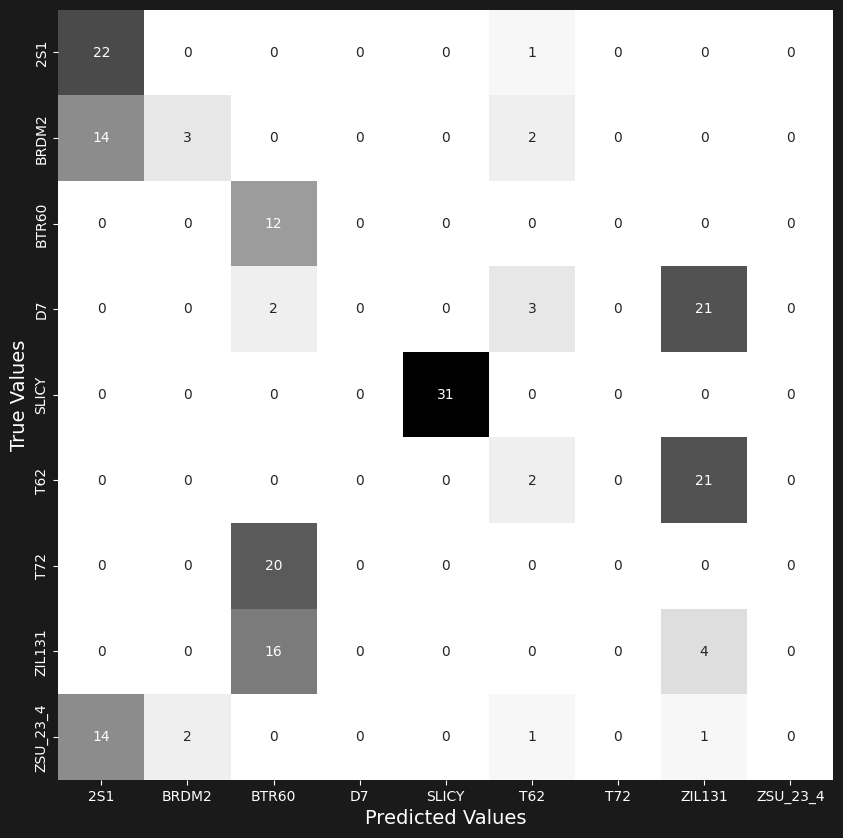

In [35]:
plot_cm(CNN, test_ds)

# Model 2 CNN

In [36]:
model2 = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(image_size + (1,))),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)       

In [37]:
model2.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=metrics)


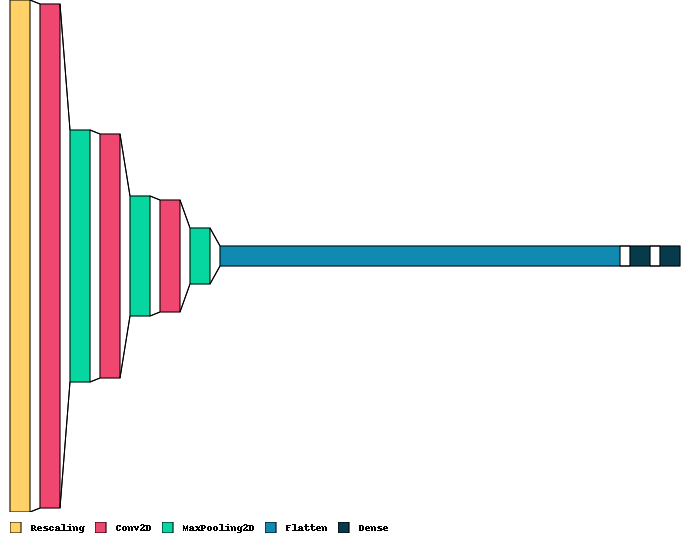

In [38]:
visualkeras.layered_view(model2, legend=True,draw_volume=False)

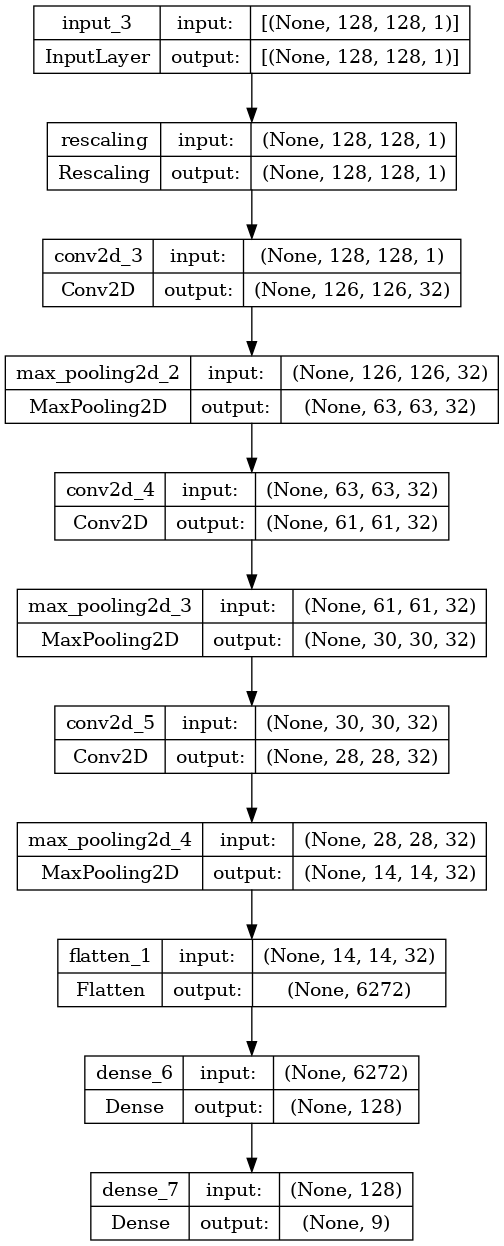

In [39]:
# display model structure
from tensorflow.keras.utils import plot_model, model_to_dot
plot_model(model2, 'model2.png', show_shapes=True)

In [40]:
history2 = model2.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
123/123 [==============================] - 5s 15ms/step - loss: 1.0008 - categorical_accuracy: 0.6333 - MCC: 0.5881 - F2: 0.6322 - auc: 0.9368 - prc: 0.7479 - val_loss: 0.2795 - val_categorical_accuracy: 0.9414 - val_MCC: 0.9349 - val_F2: 0.9403 - val_auc: 0.9965 - val_prc: 0.9820
Epoch 2/10
123/123 [==============================] - 1s 9ms/step - loss: 0.1184 - categorical_accuracy: 0.9749 - MCC: 0.9718 - F2: 0.9749 - auc: 0.9988 - prc: 0.9939 - val_loss: 0.1685 - val_categorical_accuracy: 0.9478 - val_MCC: 0.9423 - val_F2: 0.9464 - val_auc: 0.9969 - val_prc: 0.9843
Epoch 3/10
123/123 [==============================] - 1s 9ms/step - loss: 0.1073 - categorical_accuracy: 0.9665 - MCC: 0.9623 - F2: 0.9665 - auc: 0.9990 - prc: 0.9944 - val_loss: 0.0435 - val_categorical_accuracy: 0.9898 - val_MCC: 0.9885 - val_F2: 0.9898 - val_auc: 0.9993 - val_prc: 0.9988
Epoch 4/10
123/123 [==============================] - 1s 9ms/step - loss: 0.0217 - categorical_accuracy: 0.9959 - MCC: 0.99

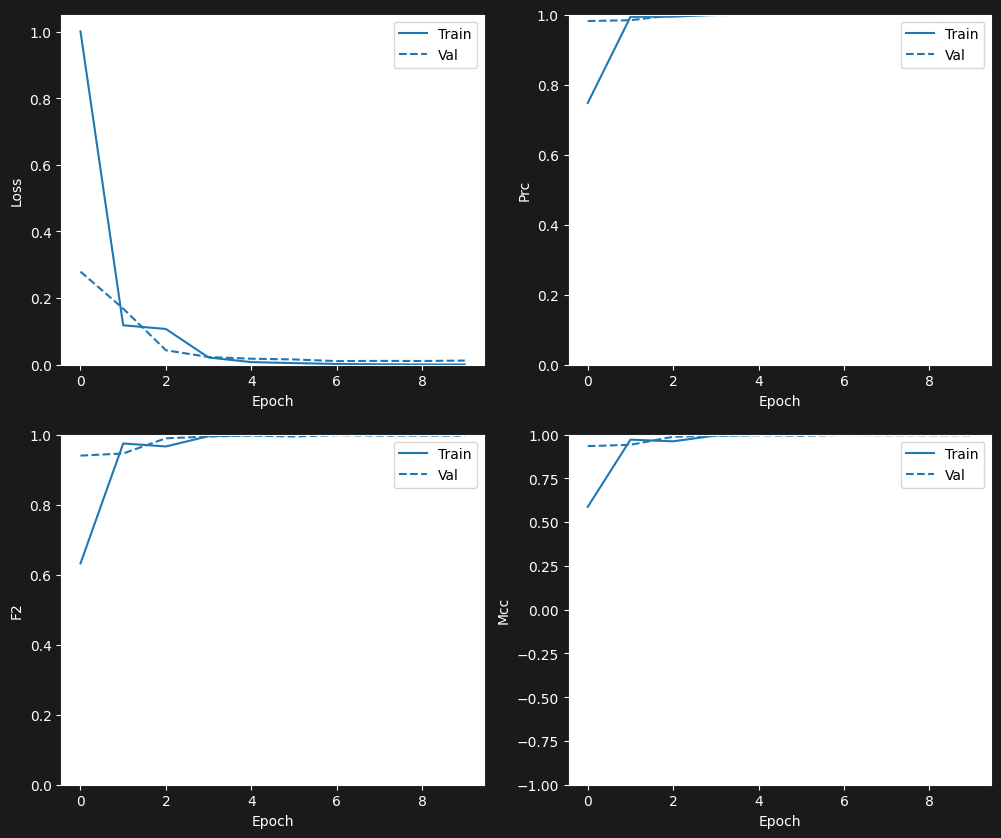

In [41]:
plot_metrics(history2)

1/1 [==============================] - 0s 83ms/step


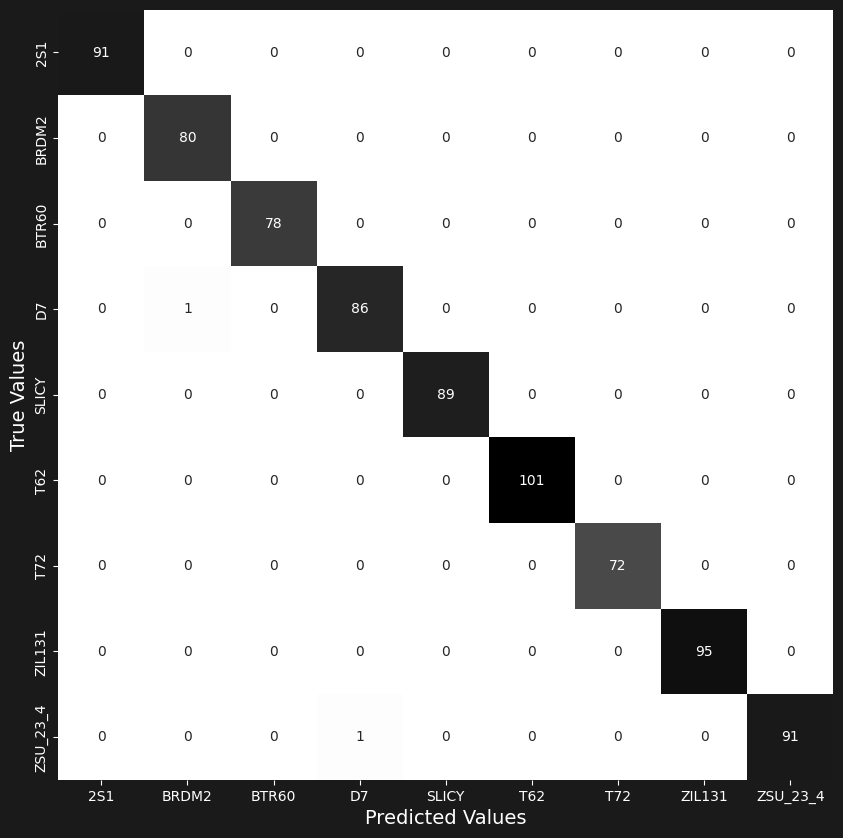

In [42]:
plot_cm(model2, val_ds)

In [43]:
holdout_results(model2)

6/6 [==============================] - 0s 9ms/step - loss: 0.0179 - categorical_accuracy: 0.9948 - MCC: 0.9941 - F2: 0.9948 - auc: 1.0000 - prc: 0.9998


{'loss': 0.01790197566151619,
 'categorical_accuracy': 0.9947916865348816,
 'MCC': 0.9941287636756897,
 'F2': 0.9947527647018433,
 'auc': 0.9999797344207764,
 'prc': 0.9998376369476318}

In [44]:
predict_t72(model2)

1/1 [==============================] - 0s 56ms/step


'This image most likely belongs to T72 with a 25.36 percent confidence.'

1/1 [==============================] - 0s 16ms/step


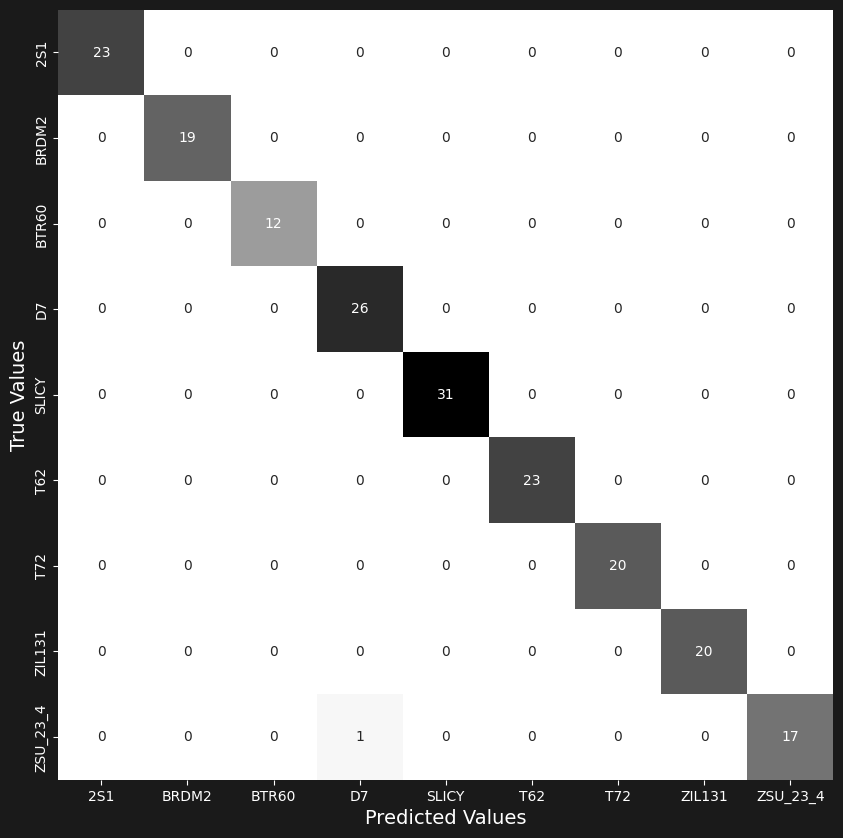

In [45]:
plot_cm(model2, test_ds)

# Benchmark Model Xception

In [46]:
resize_and_rescale = tf.keras.Sequential([
  keras.layers.Resizing(128,128),
  keras.layers.Rescaling(1./255)])

In [47]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal_and_vertical"),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomZoom(0.1),
    ]
)

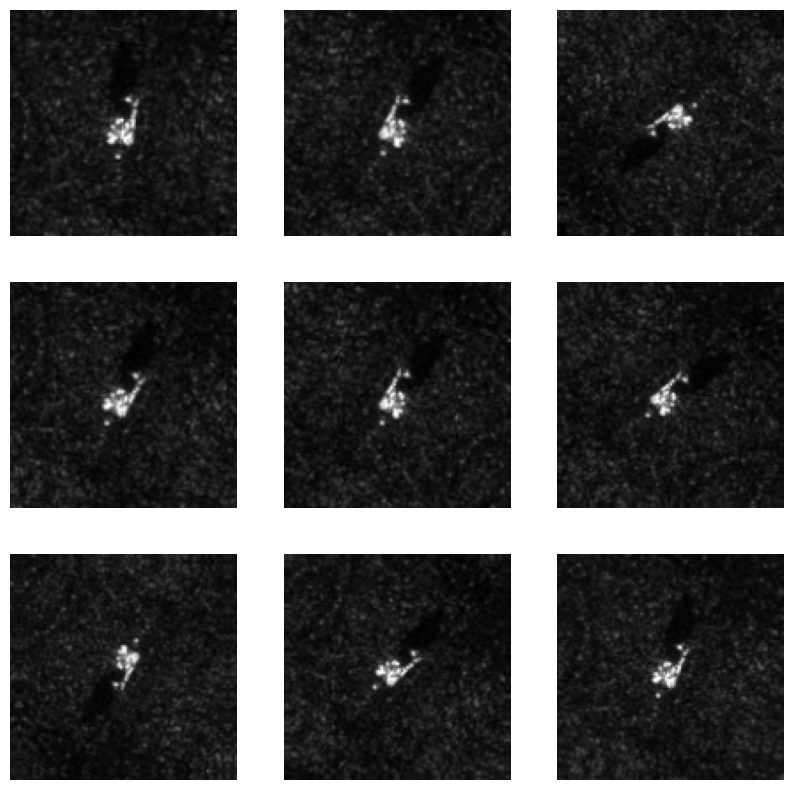

In [48]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"), cmap='gray')
        plt.axis("off")

In [49]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = resize_and_rescale(inputs)
    x = data_augmentation(x)

    # Entry block
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    x = keras.layers.Conv2D(64, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    x = keras.layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


xception = make_model(input_shape=image_size + (1,), num_classes=9)
xception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_3 (Sequential)      (None, 128, 128, 1)  0           ['input_4[0][0]']                
                                                                                                  
 sequential_4 (Sequential)      (None, 128, 128, 1)  0           ['sequential_3[0][0]']           
                                                                                                  
 conv2d_6 (Conv2D)              (None, 64, 64, 32)   320         ['sequential_4[0][0]']       

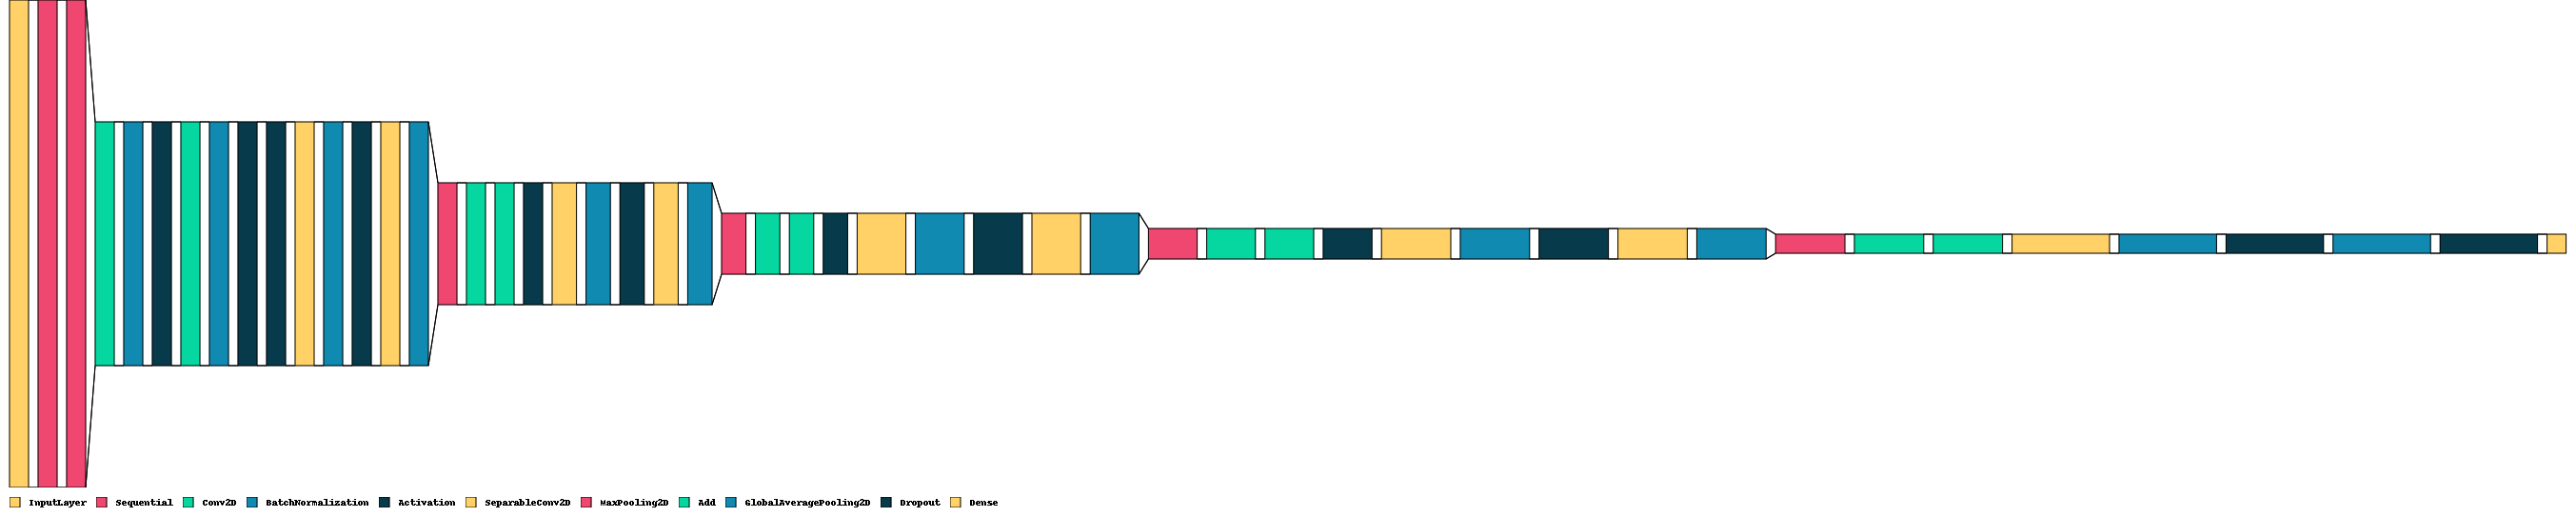

In [50]:
visualkeras.layered_view(xception, legend=True,draw_volume=False)

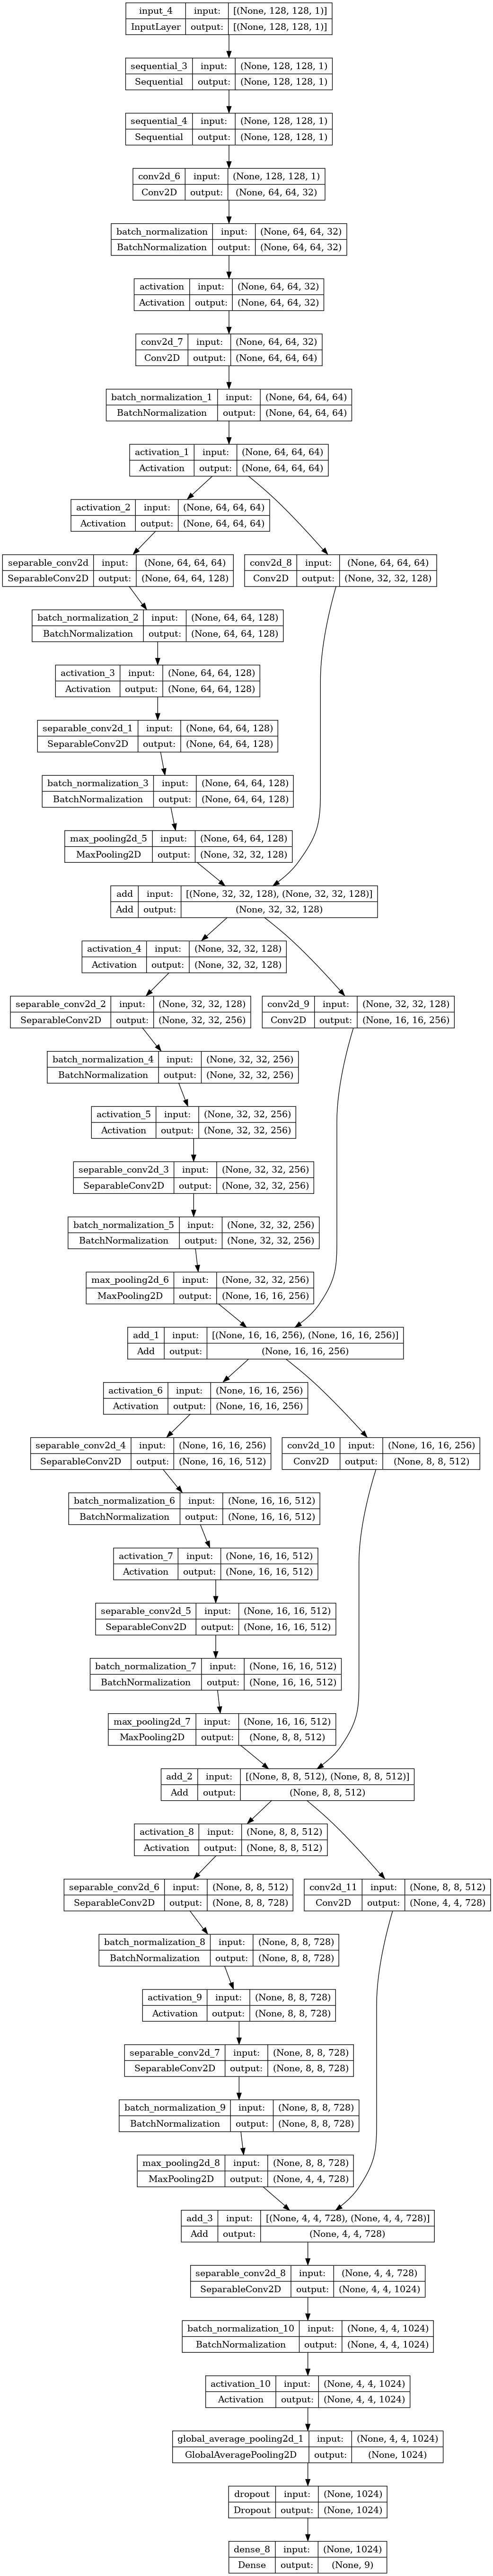

In [51]:
# display model structure
from tensorflow.keras.utils import plot_model, model_to_dot
plot_model(xception, 'xception.png', show_shapes=True)

In [52]:
callbacks=[
        keras.callbacks.EarlyStopping(patience=10, verbose=1, monitor='val_F2', mode='max', restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ]
xception.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=metrics,
)
xception_hist = xception.fit(
    train_ds, epochs=100, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/100
123/123 [==============================] - 22s 66ms/step - loss: 1.0461 - categorical_accuracy: 0.6165 - MCC: 0.5678 - F2: 0.6156 - auc: 0.9381 - prc: 0.7030 - val_loss: 3.5118 - val_categorical_accuracy: 0.1210 - val_MCC: 0.0000e+00 - val_F2: 0.0493 - val_auc: 0.5343 - val_prc: 0.1217 - lr: 0.0010
Epoch 2/100
123/123 [==============================] - 7s 54ms/step - loss: 0.7313 - categorical_accuracy: 0.7233 - MCC: 0.6882 - F2: 0.7229 - auc: 0.9649 - prc: 0.8021 - val_loss: 7.5051 - val_categorical_accuracy: 0.1210 - val_MCC: 0.0000e+00 - val_F2: 0.0493 - val_auc: 0.5245 - val_prc: 0.1195 - lr: 0.0010
Epoch 3/100
123/123 [==============================] - 6s 53ms/step - loss: 0.5814 - categorical_accuracy: 0.7793 - MCC: 0.7513 - F2: 0.7791 - auc: 0.9767 - prc: 0.8670 - val_loss: 17.4352 - val_categorical_accuracy: 0.1210 - val_MCC: 0.0000e+00 - val_F2: 0.0493 - val_auc: 0.5096 - val_prc: 0.1142 - lr: 0.0010
Epoch 4/100
123/123 [==============================] - ETA: 0s - 

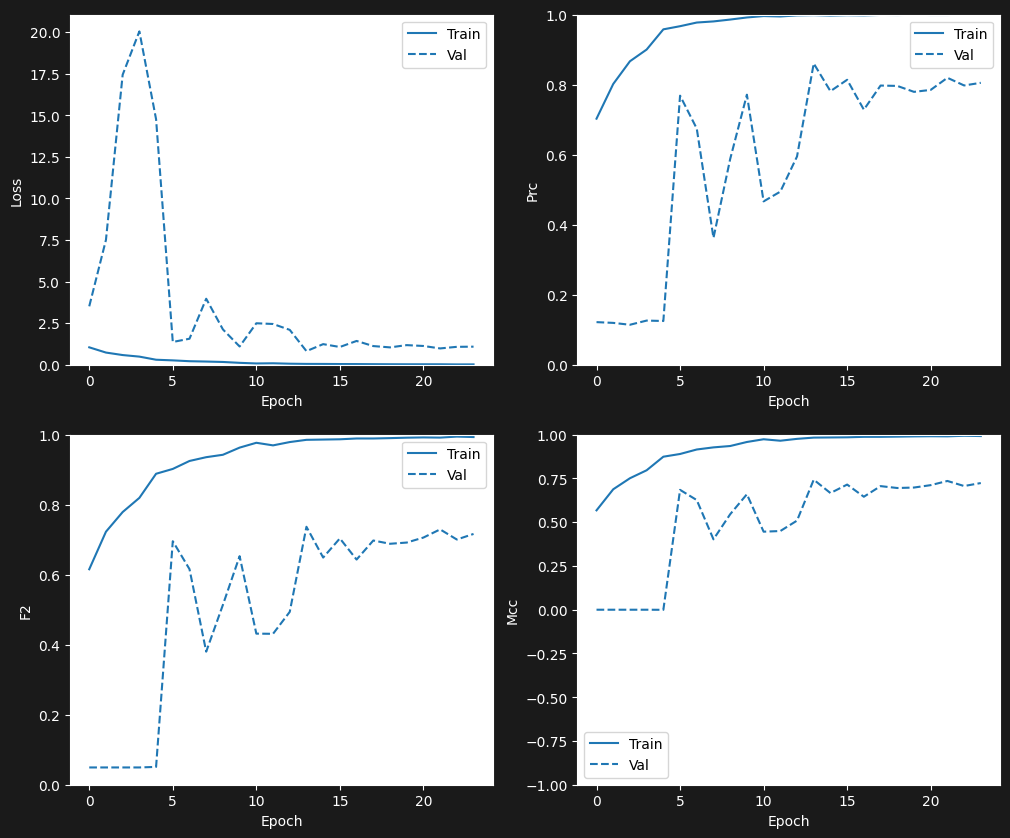

In [53]:
plot_metrics(xception_hist)

1/1 [==============================] - 0s 304ms/step


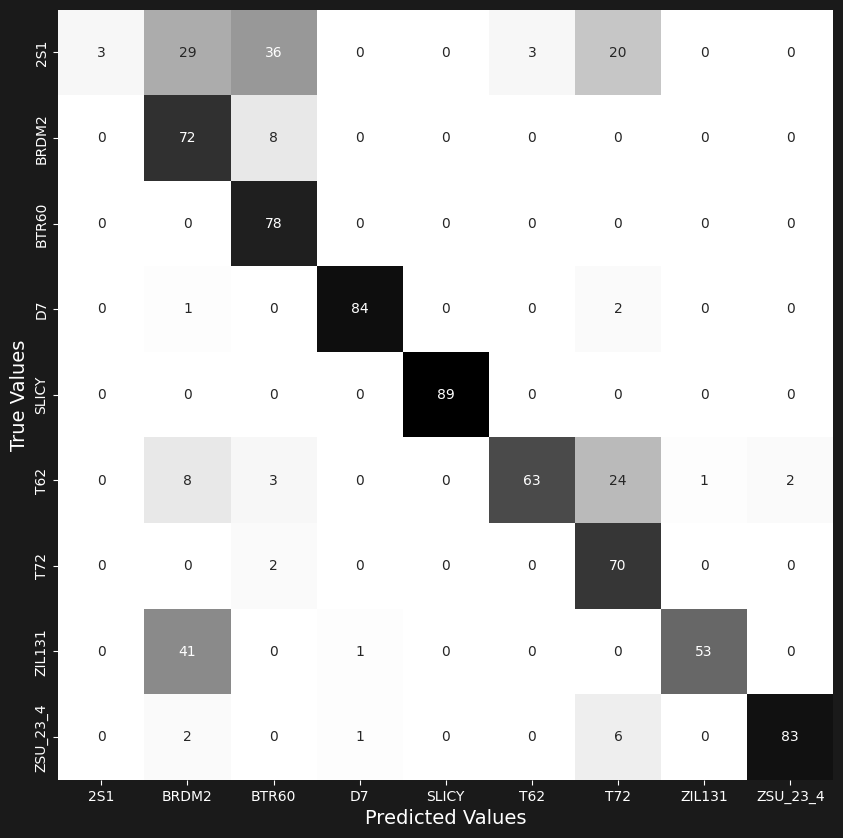

In [54]:
plot_cm(xception, val_ds)

In [55]:
holdout_results(xception)

6/6 [==============================] - 0s 21ms/step - loss: 0.7668 - categorical_accuracy: 0.7812 - MCC: 0.7666 - F2: 0.7605 - auc: 0.9683 - prc: 0.8820


{'loss': 0.7667766213417053,
 'categorical_accuracy': 0.78125,
 'MCC': 0.7665793299674988,
 'F2': 0.760543704032898,
 'auc': 0.9682955741882324,
 'prc': 0.882007360458374}

In [56]:
predict_t72(xception)

1/1 [==============================] - 0s 213ms/step


'This image most likely belongs to T72 with a 25.36 percent confidence.'

1/1 [==============================] - 0s 18ms/step


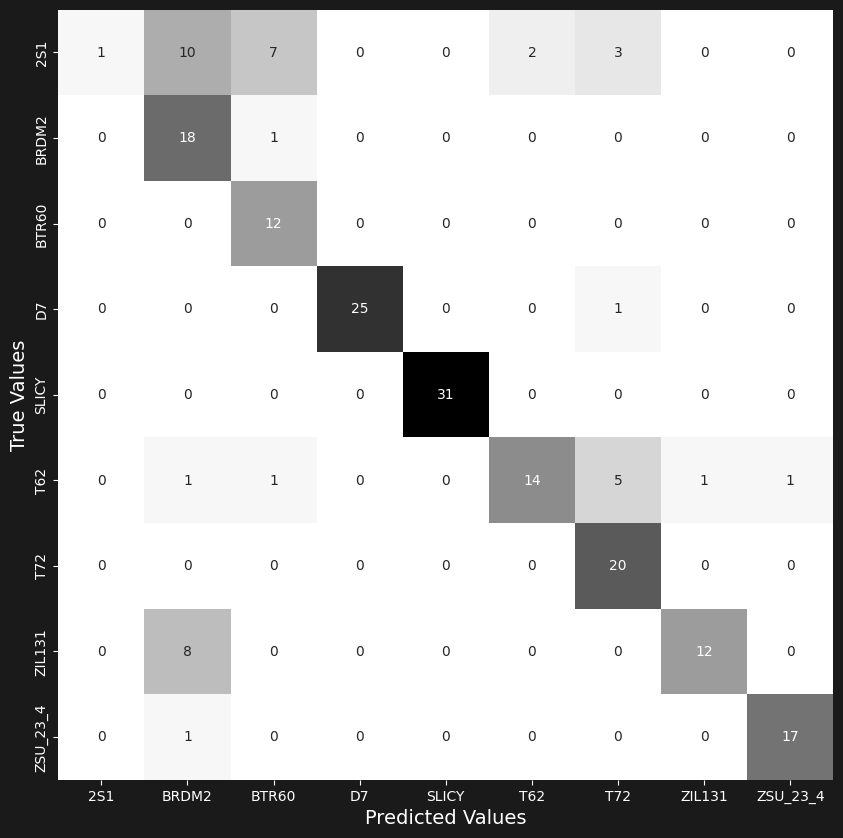

In [57]:
plot_cm(xception,test_ds)

# Benchmark Model VGG19

In [58]:
train_ds = image_dataset_from_directory('/kaggle/input/mstar-8-classes/MSTAR-8-Classes',
                                           subset='training',
                                           image_size=image_size,
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='rgb',
                                           batch_size=batch_size)

val_ds = image_dataset_from_directory('/kaggle/input/mstar-8-classes/MSTAR-8-Classes',
                                           subset='validation',
                                           image_size=image_size,
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='rgb',
                                           batch_size=batch_size)

Found 4887 files belonging to 9 classes.
Using 3910 files for training.
Found 4887 files belonging to 9 classes.
Using 977 files for validation.


In [59]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 25
Number of test batches: 6


In [60]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

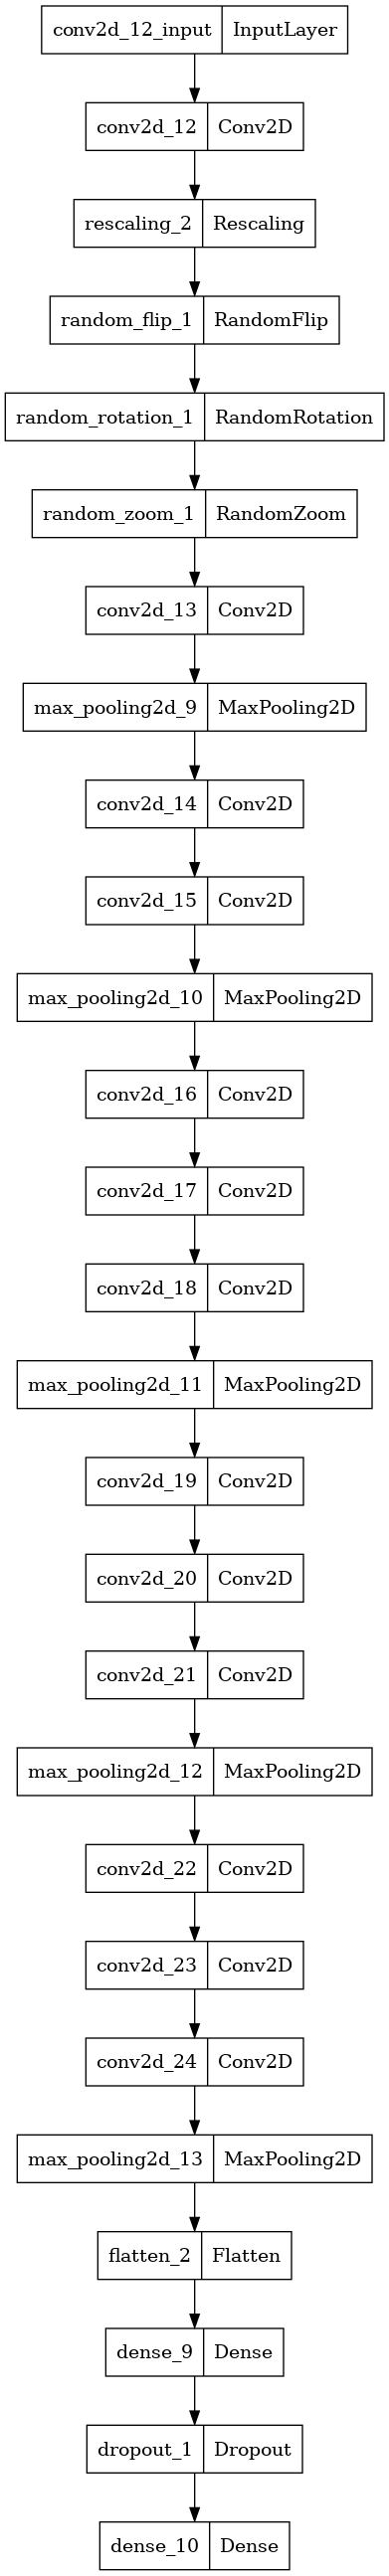

In [62]:
vgg_model = keras.models.Sequential()
vgg_model.add(Conv2D(input_shape=(128,128,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg_model.add(Rescaling(1./255))
vgg_model.add(RandomFlip('horizontal_and_vertical'))
vgg_model.add(RandomRotation(0.2))
vgg_model.add(RandomZoom(0.1))
vgg_model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg_model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg_model.add(Flatten())
vgg_model.add(Dense(1024, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(num_classes, activation='softmax'))


keras.utils.plot_model(vgg_model)

In [64]:
vgg_model.compile(
    optimizer=keras.optimizers.Adam(1e-6),
    loss="categorical_crossentropy",
    metrics=metrics,)

vgg_hist = vgg_model.fit(
    train_ds, epochs=200, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/200
123/123 [==============================] - 27s 134ms/step - loss: 2.1959 - categorical_accuracy: 0.1967 - MCC: 0.1010 - F2: 0.1617 - auc: 0.5686 - prc: 0.1714 - val_loss: 2.1946 - val_categorical_accuracy: 0.1987 - val_MCC: 0.1408 - val_F2: 0.1161 - val_auc: 0.5544 - val_prc: 0.1260 - lr: 1.0000e-06
Epoch 2/200
123/123 [==============================] - 14s 117ms/step - loss: 2.1903 - categorical_accuracy: 0.1954 - MCC: 0.1148 - F2: 0.1201 - auc: 0.5556 - prc: 0.1559 - val_loss: 2.1849 - val_categorical_accuracy: 0.1975 - val_MCC: 0.1371 - val_F2: 0.1149 - val_auc: 0.5420 - val_prc: 0.1628 - lr: 1.0000e-06
Epoch 3/200
123/123 [==============================] - 14s 117ms/step - loss: 2.1611 - categorical_accuracy: 0.2031 - MCC: 0.1264 - F2: 0.1240 - auc: 0.5651 - prc: 0.1791 - val_loss: 2.1488 - val_categorical_accuracy: 0.1936 - val_MCC: 0.1339 - val_F2: 0.1131 - val_auc: 0.5864 - val_prc: 0.2286 - lr: 1.0000e-06
Epoch 4/200
123/123 [==============================] - 14s 11

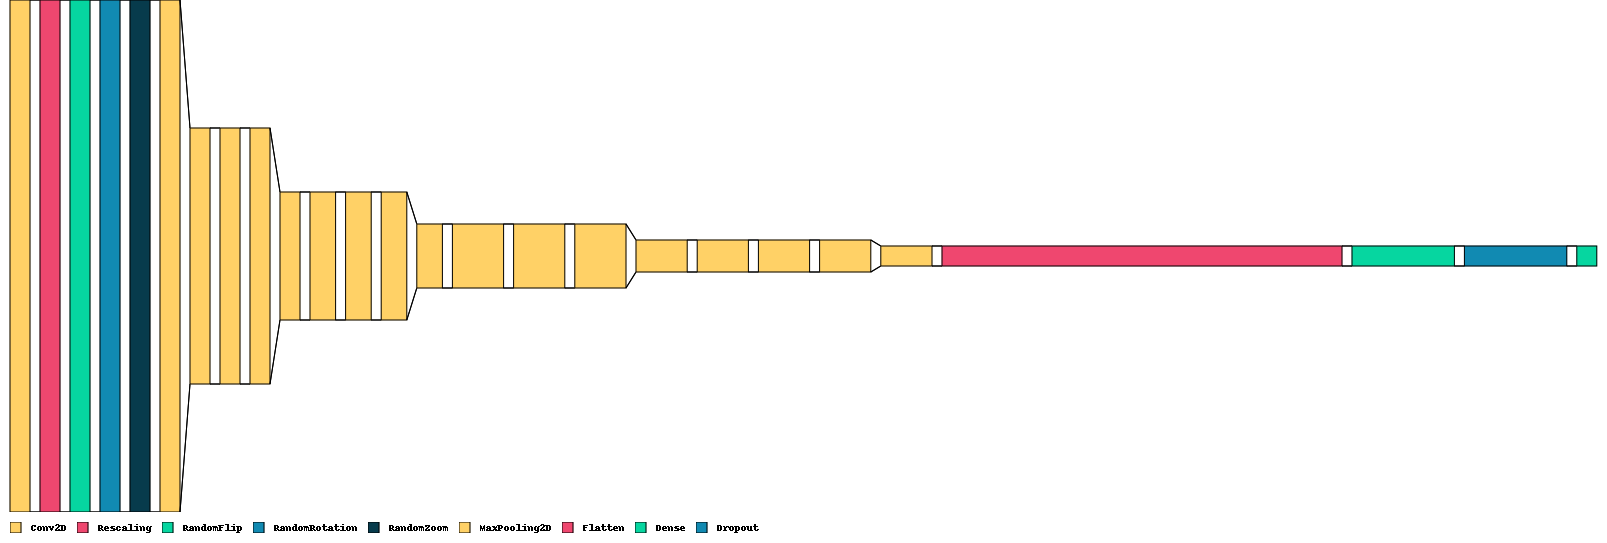

In [65]:
visualkeras.layered_view(vgg_model, legend=True,draw_volume=False)

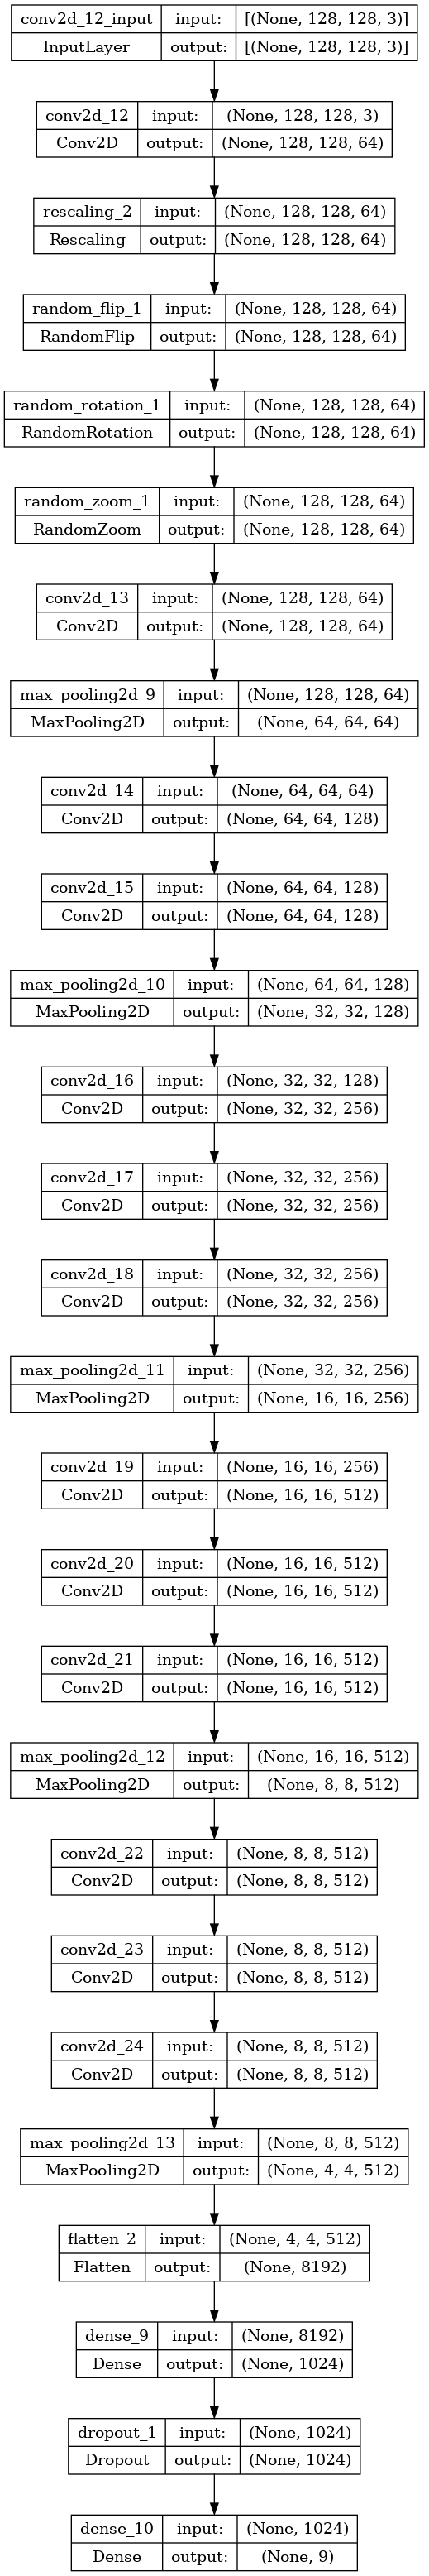

In [66]:
# display model structure
from tensorflow.keras.utils import plot_model, model_to_dot
plot_model(vgg_model, 'vgg_model.png', show_shapes=True)

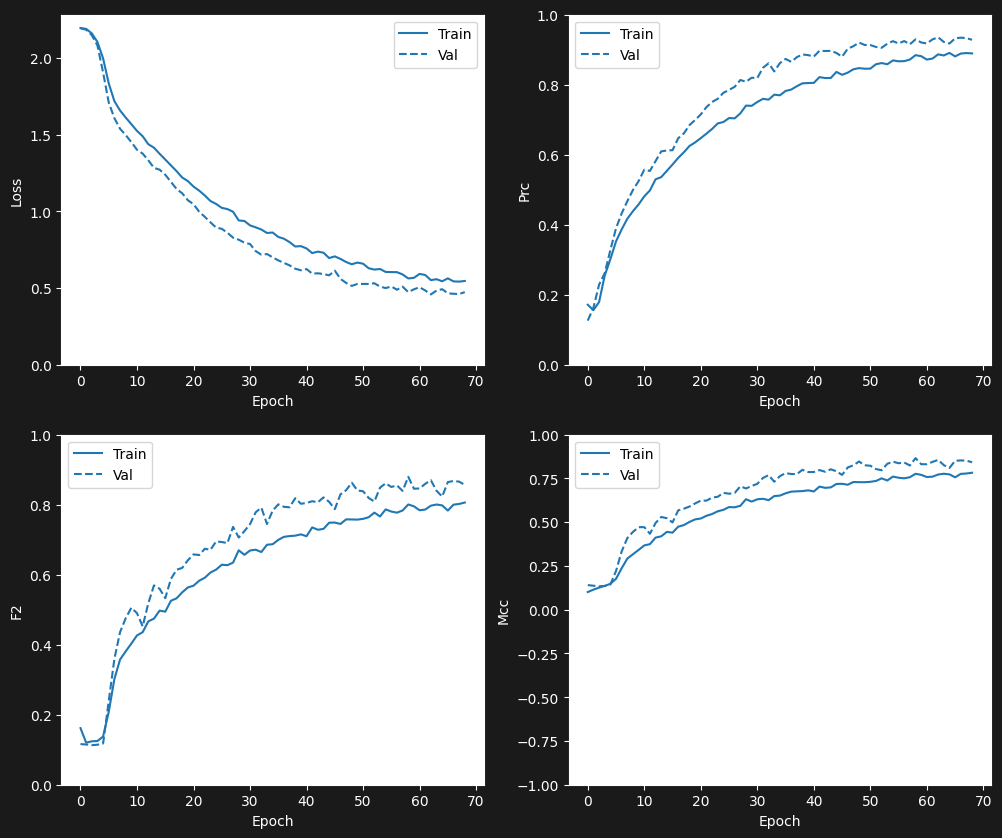

In [67]:
plot_metrics(vgg_hist)

1/1 [==============================] - 0s 152ms/step


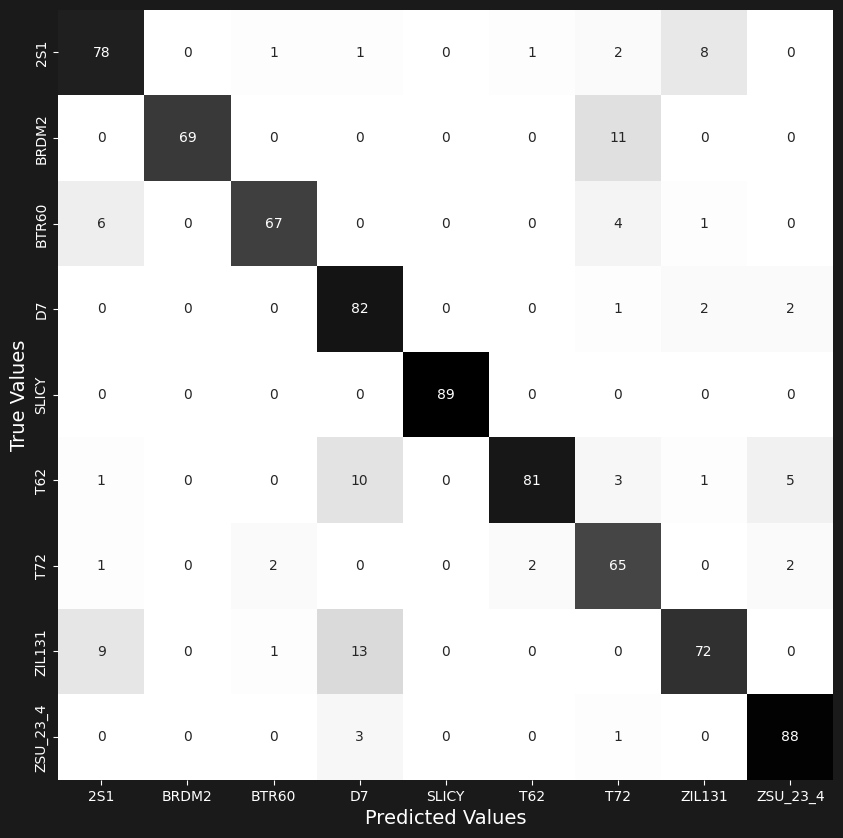

In [68]:
plot_cm(vgg_model, val_ds)

In [69]:
holdout_results(vgg_model)

6/6 [==============================] - 0s 32ms/step - loss: 0.3926 - categorical_accuracy: 0.9010 - MCC: 0.8893 - F2: 0.8988 - auc: 0.9941 - prc: 0.9622


{'loss': 0.3925924003124237,
 'categorical_accuracy': 0.9010416865348816,
 'MCC': 0.8892704248428345,
 'F2': 0.8987763524055481,
 'auc': 0.9941050410270691,
 'prc': 0.9622418880462646}

In [70]:
image = keras.utils.load_img(
    path="/kaggle/input/mstar-8-classes/MSTAR-8-Classes/T72/HB03351.jpeg",
    color_mode='rgb',
    target_size=(128,128)
)

image

image_array = keras.utils.img_to_array(image)
image_array = tf.expand_dims(image_array, 0)

In [71]:
predict_t72(vgg_model)

1/1 [==============================] - 0s 186ms/step


'This image most likely belongs to SLICY with a 21.40 percent confidence.'

1/1 [==============================] - 0s 21ms/step


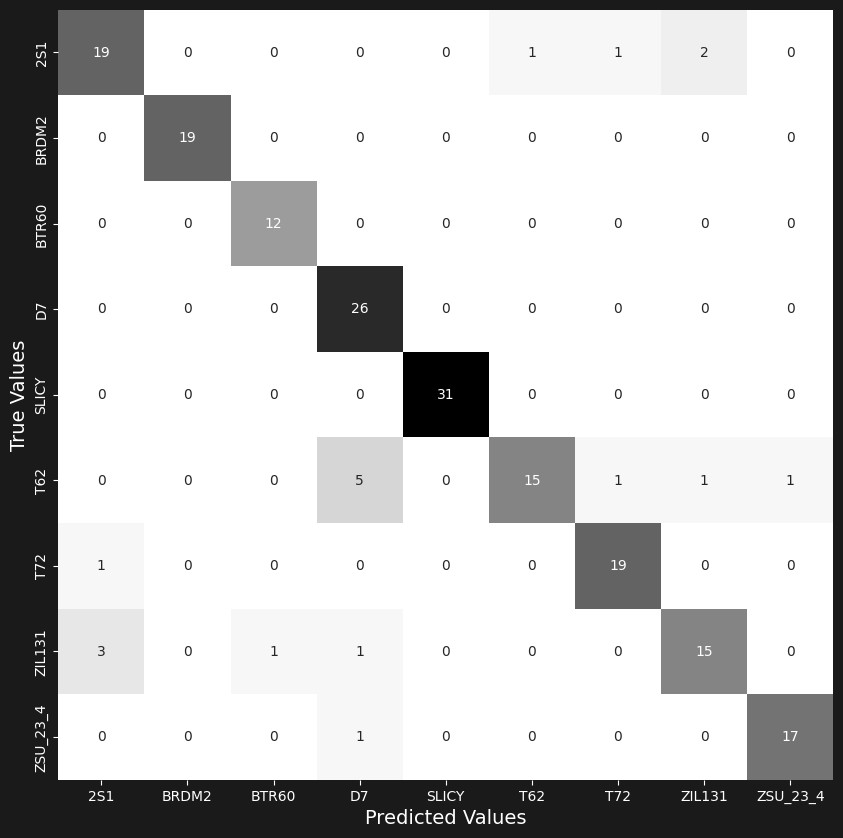

In [72]:
plot_cm(vgg_model,test_ds)

# MODEL 3 Modified CNN

In [73]:
last_model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(image_size + (3,))),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.Conv2D(128, 5, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 4, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 2, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])
last_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 128, 128, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 128, 128, 3)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 124, 124, 128)     9728      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 62, 62, 128)      0         
 g2D)                                                 

In [74]:
last_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=metrics,)

last_model_hist = last_model.fit(
    train_ds, epochs=100, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/100
123/123 [==============================] - 8s 35ms/step - loss: 1.6789 - categorical_accuracy: 0.3647 - MCC: 0.2843 - F2: 0.3548 - auc: 0.8188 - prc: 0.4342 - val_loss: 1.1454 - val_categorical_accuracy: 0.5223 - val_MCC: 0.4802 - val_F2: 0.4816 - val_auc: 0.9276 - val_prc: 0.6284 - lr: 0.0010
Epoch 2/100
123/123 [==============================] - 3s 28ms/step - loss: 1.2104 - categorical_accuracy: 0.5284 - MCC: 0.4694 - F2: 0.5237 - auc: 0.9073 - prc: 0.6033 - val_loss: 0.7168 - val_categorical_accuracy: 0.7338 - val_MCC: 0.7054 - val_F2: 0.7262 - val_auc: 0.9694 - val_prc: 0.8088 - lr: 0.0010
Epoch 3/100
123/123 [==============================] - 3s 28ms/step - loss: 0.8976 - categorical_accuracy: 0.6611 - MCC: 0.6183 - F2: 0.6599 - auc: 0.9490 - prc: 0.7509 - val_loss: 0.4560 - val_categorical_accuracy: 0.8446 - val_MCC: 0.8275 - val_F2: 0.8416 - val_auc: 0.9882 - val_prc: 0.9205 - lr: 0.0010
Epoch 4/100
123/123 [==============================] - 3s 28ms/step - loss: 0.7

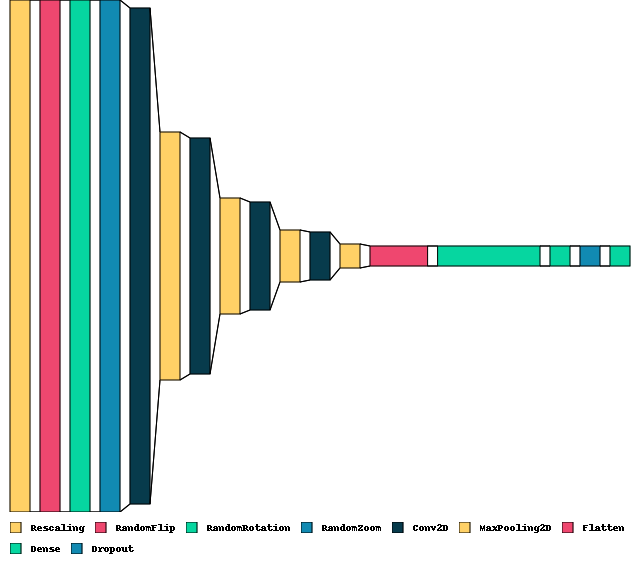

In [75]:
visualkeras.layered_view(last_model, legend=True,draw_volume=False)

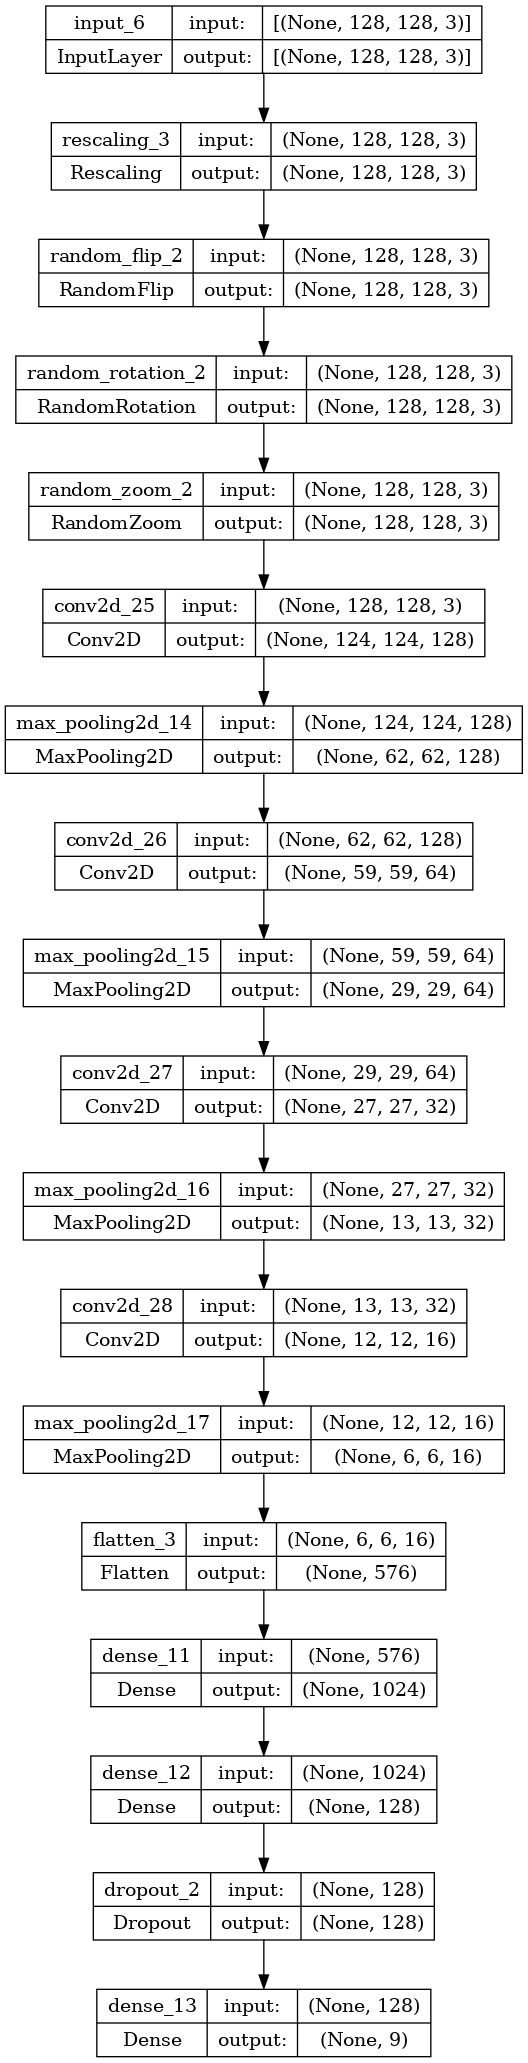

In [76]:
# display model structure
from tensorflow.keras.utils import plot_model, model_to_dot
plot_model(last_model, 'last_model.png', show_shapes=True)

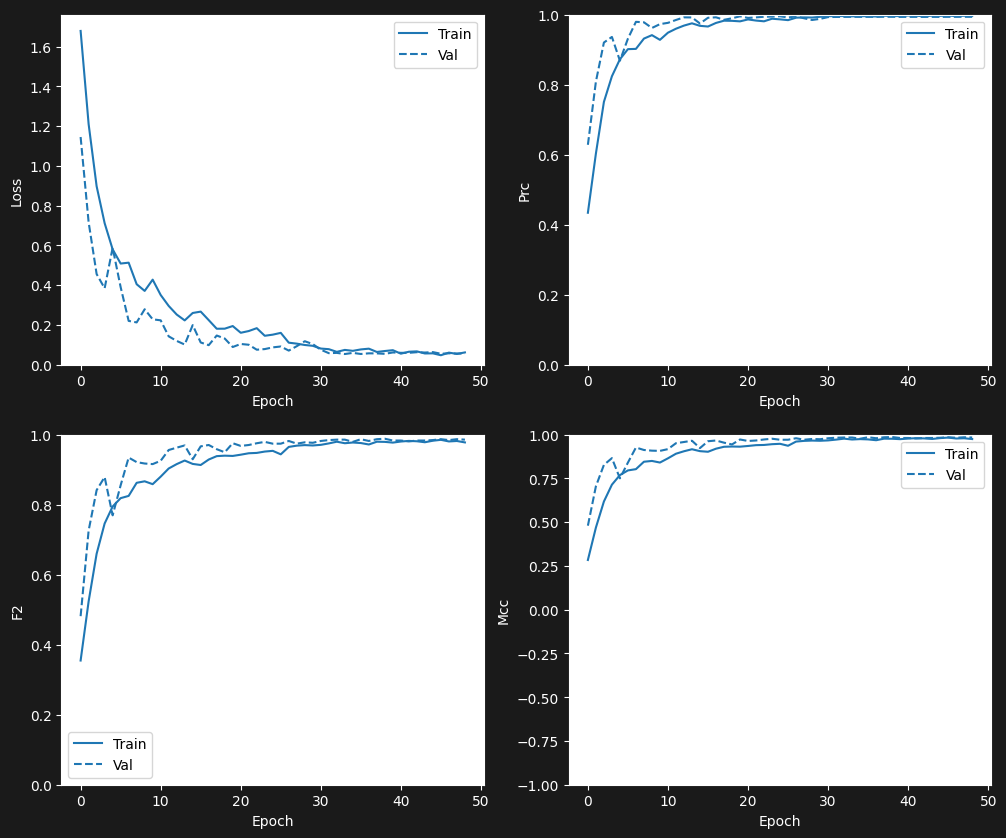

In [77]:
plot_metrics(last_model_hist)

1/1 [==============================] - 0s 99ms/step


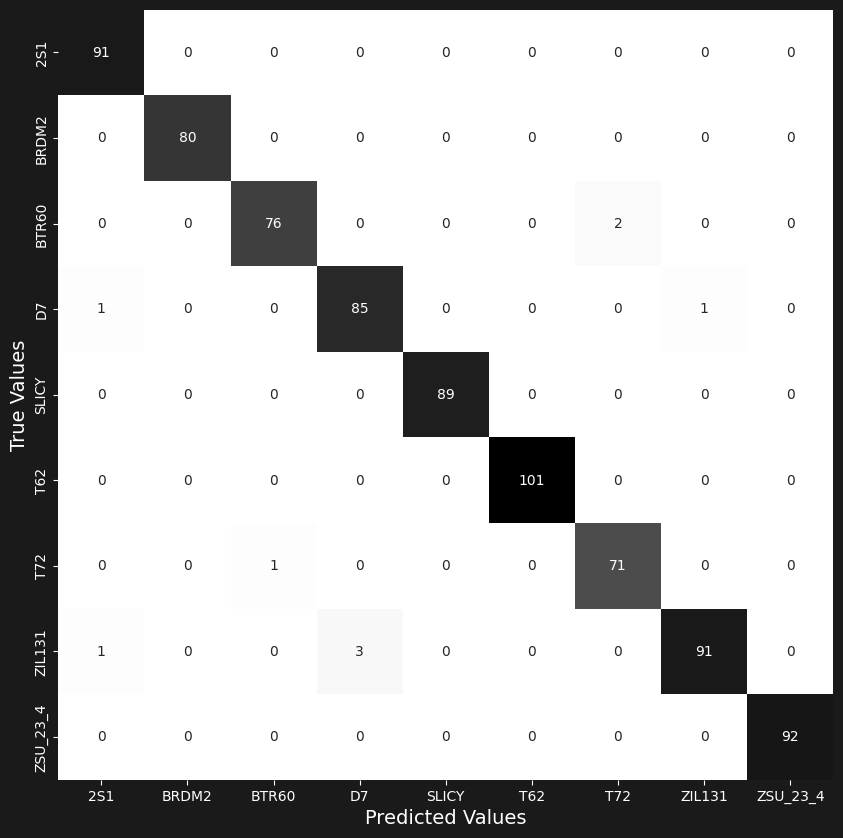

In [78]:
plot_cm(last_model, val_ds)

In [79]:
holdout_results(last_model)

6/6 [==============================] - 0s 15ms/step - loss: 0.0140 - categorical_accuracy: 0.9948 - MCC: 0.9941 - F2: 0.9948 - auc: 1.0000 - prc: 1.0000


{'loss': 0.014037217013537884,
 'categorical_accuracy': 0.9947916865348816,
 'MCC': 0.9941301345825195,
 'F2': 0.9947640299797058,
 'auc': 0.9999966025352478,
 'prc': 0.9999729990959167}

In [80]:
predict_t72(last_model)

1/1 [==============================] - 0s 63ms/step


'This image most likely belongs to T72 with a 25.36 percent confidence.'

1/1 [==============================] - 0s 23ms/step


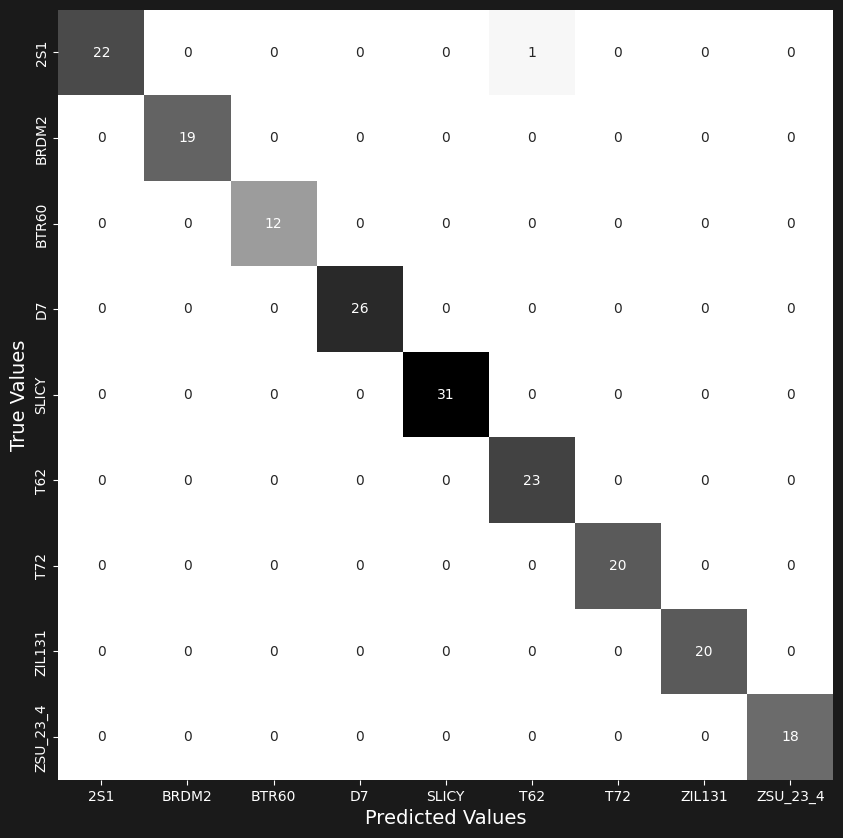

In [81]:
plot_cm(last_model, test_ds)